# XGBoost Model
This is by far the most accurate modelling technique for structed data. We will use a datapipeline for this as well. This improves future flexibility of the model.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np

In [44]:
import pandas as pd
import xgboost as xgb
import sys
sys.path.append('../')
from dataflow import Flow

my_flow = Flow(None, None, None, csv_path='../neural_network/csv/preselected_feat_v5.0.6_equalRatio_restrictedSideband.csv')
all_data = my_flow.get_combined_data()
(X_train, y_train), (X_val, y_val), (X_test, y_test) = my_flow.get_train_val_test_split()

In [36]:
def plot_prob_dist(probs, bins, savefig=None):
    probs = list(probs)
    labels = ['Train', 'Validation', 'Test']
    colours = ['b', 'r', 'g']
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    fonts = {'fontname':'Arial'}
    
    for i, p in enumerate(probs):
        ax.hist(p, bins=bins, histtype='step', label=labels[i], density=True, color=colours[i], linewidth=2)
    
    plt.ylabel('Normalised Frequency', horizontalalignment='right', y=1.0, fontsize=14, **fonts)
    plt.xlabel('Probability', horizontalalignment='right', x=1.0, fontsize=14, **fonts)
    plt.legend(loc='upper right', bbox_to_anchor=(0.7, 0.95), ncol=1, fancybox=False, shadow=True, frameon=False)
    if savefig != None:
        plt.savefig(savefig)
    plt.show()

## Define the Model
Now we have our data (the same as was used by the neural network) we try to see how well we can get this to perform. We will be using an XGBClassifier. This is by far the best method to use for this binary classification problem. 

In [46]:
feature_cols = [f for f in all_data.columns.to_list() if f != 'category']
data_dmatrix = xgb.DMatrix(data=all_data[feature_cols], label=all_data.category)

In [47]:
# Parameters for the model
params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'eval_metric': ['auc', 'logloss'],
    'use_label_encoder': False
}

# Instantiate the classifier
xgb_clf = xgb.XGBClassifier(**params)

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['auc', 'logloss'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=32, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [50]:
# Check the accuracy score
from sklearn.metrics import accuracy_score, roc_auc_score

y_pred = xgb_clf.predict(X_val)
acc, roc_auc = accuracy_score(y_val, y_pred), roc_auc_score(y_val, y_pred)
print(f'Primitive Model Accuracy: {acc:.4f}\nPrimitive Model ROC-AUC: {roc_auc:.4f}')

Primitive Model Accuracy: 0.9453
Primitive Model ROC-AUC: 0.9453


/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


## Feature Importance Analysis

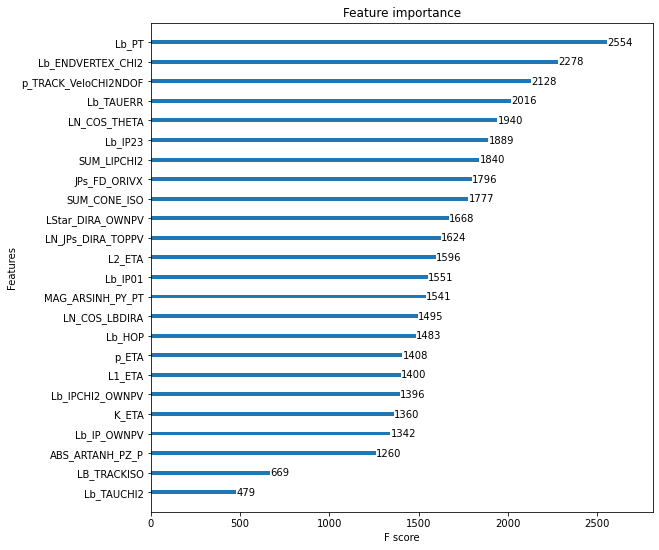

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
xgb.plot_importance(xgb_clf, ax=ax, grid=False)
plt.savefig('../../images/MLModels/feature_importance_xgb_v5.0.6.png')
plt.show()

In [52]:
y_pred_probs_test = xgb_clf.predict_proba(X_test)
y_pred_probs_val = xgb_clf.predict_proba(X_val)
y_pred_probs_train = xgb_clf.predict_proba(X_train)

/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


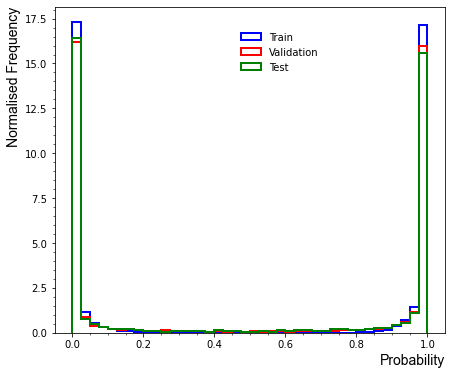

In [53]:
probs = [
    y_pred_probs_train[:,1],
    y_pred_probs_val[:,1],
    y_pred_probs_test[:,1]
]

plot_prob_dist(probs, np.linspace(0, 1, 41), savefig='../../images/MLModels/XGB_v5.0.6_ProbDist.png')